# Adversarial Robustness

In [1]:
! pip install torchattacks

import numpy as np
with open('./saved_data.npy', 'rb') as f:
    epsilons_ = np.load(f)
    accuracy_naturel_wide_Resnet50_2 = np.load(f)
    accuracy_adv_training_wide_Resnet50_2 = np.load(f)
    accuracy_adv_training_noise_wide_Resnet50_2 = np.load(f)
    accuracies_autoencodeur_wide_Resnet50_2 = np.load(f)
    accuracies_autoencodeur_noise_wide_Resnet50_2 = np.load(f)

In [23]:
%load_ext autoreload
%autoreload 2

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA Available:  False


## Models

In [4]:
from models import create_wideResnet50_2, create_Resnet50_2

wide_resnet50_2 = create_wideResnet50_2(device)
resnet20 = create_Resnet50_2(device)

Using cache found in /home/imaginat0r/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


## DDSA

In [5]:
from models import create_ddsa

# Autoencodeur DDSA
autoencoder = create_ddsa(device)
print(autoencoder)

DDSA(
  (enc1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (enc2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (enc3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (dec1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dec2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (dec3): ConvTranspose2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (final_layer): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=4608, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=2048, bias=True)
  (linear3): Linear(in_features=2048, out_features=4608, bias=True)
)


## Attacks

In [6]:
from attacks import PGD_linf,fgsm_attack,BIM,deepfool

## Natural training

In [7]:
from training import training

params = {"epochs" : 10,
    "epsilon" : 8/255, 
    "n_iter" : 10,
    "alpha":  0.007, 
    "num_exemples":5,
    "use_FGSM" : True,
    "use_autoencoder" : False,

    "noise_factor" : 8/255,
    "params_model":{
        "lr" : 0.00001 
    }
}

test_accuracies, test_losses = training(wide_resnet50_2,device,trainloader,testloader, params)

  0%|          | 0/391 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [37]:
from training import test_model


# torch.save(wide_resnet50_2.state_dict(), "/content/drive/MyDrive/model_CIFAR/wide_resnet50_2.pt")
loss_fn = nn.CrossEntropyLoss()
test_model(testloader,device,wide_resnet50_2,loss_fn)

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.825819


## Effect of perturbation on accuracy 

In [9]:
from evaluate import pgd_attack_effect_on_accuracy
# wide_resnet50_2.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/wide_resnet50_2.pt"))


params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "denoiser": None,
    "noise": None
}

epsilons, accuracies = pgd_attack_effect_on_accuracy(wide_resnet50_2,device,testloader,params)

Epsilon : 0.0


  0%|          | 0/79 [00:03<?, ?it/s]


KeyboardInterrupt: 

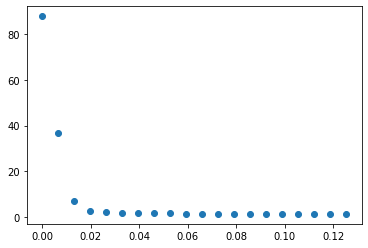

In [10]:
import matplotlib.pyplot as plt

plt.scatter(epsilons_,accuracy_naturel_wide_Resnet50_2)

# Defense Strategy I : Adversarial training

In [11]:
# resnet20 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
# resnet20.load_state_dict(torch.load("/content/cifar10_resnet20-4118986f.pt"))
# resnet20 = resnet20.to(device)

# mobilenetv2 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x0_5", pretrained=True)
# mobilenetv2_adv = copy.copy(mobilenetv2)
# mobilenetv2_adv.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/mobilenetv2_adv.pt"))


resnet20_adv = copy.copy(resnet20)
wide_resnet50_2.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/wide_resnet50_2.pt"))
resnet20_adv.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/resnet_adv_(40.96).pt"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/model_CIFAR/wide_resnet50_2.pt'

In [13]:
from training import adversarial_training

params = {"epochs" : 64,
    "epsilon" : 8/255, #epsilon infini
    "n_iter" : 10,
    "alpha": 3/255, # alpha infini

    "deepfool_steps" : 10,
    "num_exemples":5,

    "params_model":{
        "lr" : 0.001 # 0 pour freeze le modele
    }
}


resnet20_adv = copy.copy(resnet20)
adversarial_training(resnet20_adv,device,trainloader,testloader, params)

  0%|          | 0/391 [00:00<?, ?it/s]

Epsilon : 0.0


  0%|          | 0/79 [00:00<?, ?it/s]

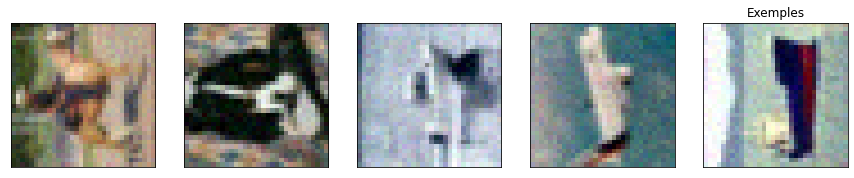

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.698399 

Epsilon : 0.006604747162022704


  0%|          | 0/79 [00:00<?, ?it/s]

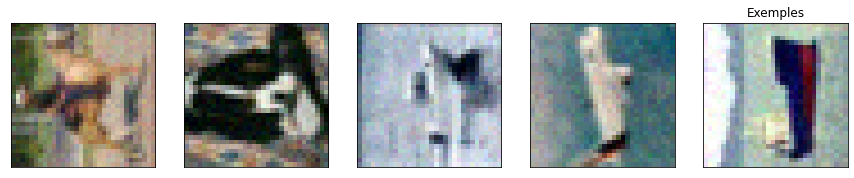

Test Error: 
 Accuracy: 71.4%, Avg loss: 0.828490 

Epsilon : 0.013209494324045407


  0%|          | 0/79 [00:00<?, ?it/s]

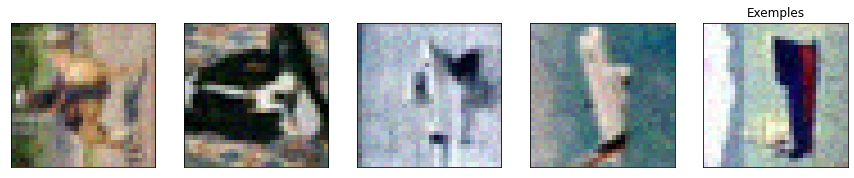

Test Error: 
 Accuracy: 64.0%, Avg loss: 0.981250 

Epsilon : 0.019814241486068113


  0%|          | 0/79 [00:00<?, ?it/s]

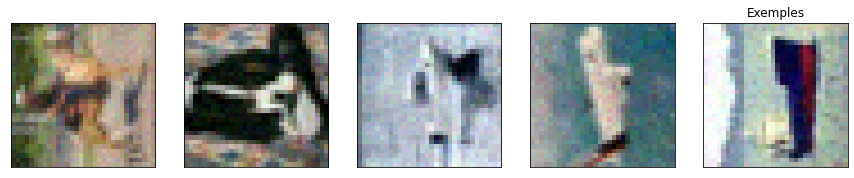

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.158095 

Epsilon : 0.026418988648090815


  0%|          | 0/79 [00:00<?, ?it/s]

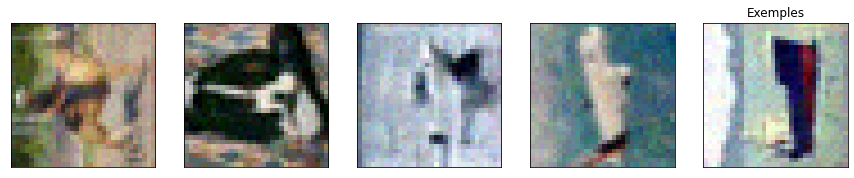

Test Error: 
 Accuracy: 48.2%, Avg loss: 1.362421 

Epsilon : 0.033023735810113516


  0%|          | 0/79 [00:00<?, ?it/s]

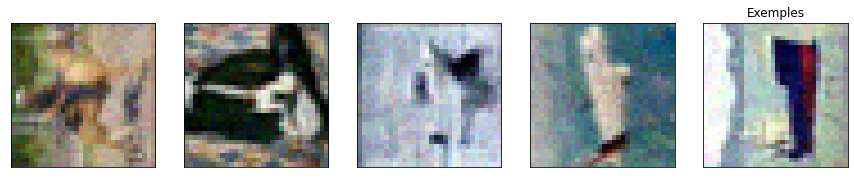

Test Error: 
 Accuracy: 39.9%, Avg loss: 1.597783 

Epsilon : 0.039628482972136225


  0%|          | 0/79 [00:00<?, ?it/s]

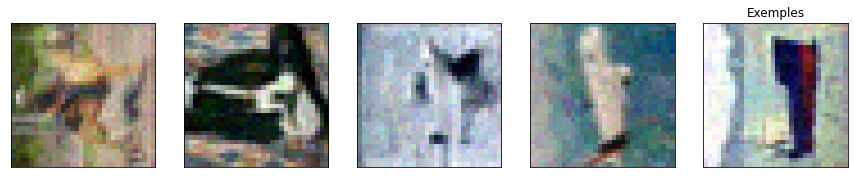

Test Error: 
 Accuracy: 32.4%, Avg loss: 1.858659 

Epsilon : 0.04623323013415893


  0%|          | 0/79 [00:00<?, ?it/s]

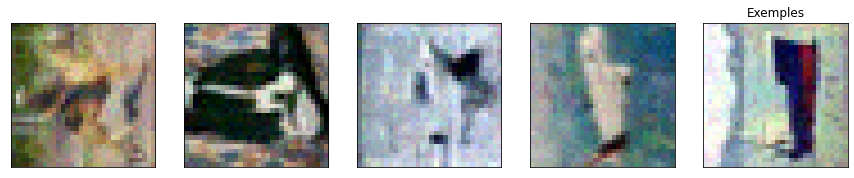

Test Error: 
 Accuracy: 25.2%, Avg loss: 2.141924 

Epsilon : 0.05283797729618163


  0%|          | 0/79 [00:00<?, ?it/s]

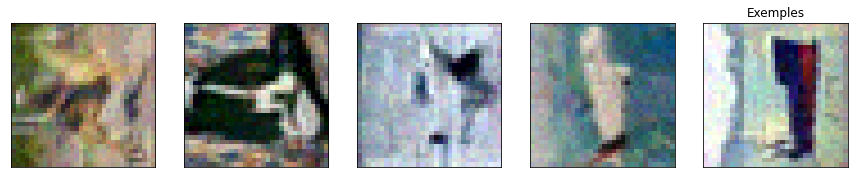

Test Error: 
 Accuracy: 19.6%, Avg loss: 2.436694 

Epsilon : 0.05944272445820433


  0%|          | 0/79 [00:00<?, ?it/s]

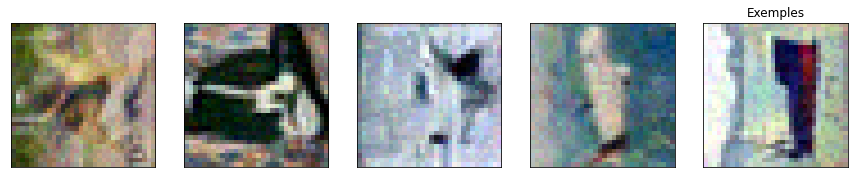

Test Error: 
 Accuracy: 15.1%, Avg loss: 2.739203 

Epsilon : 0.06604747162022703


  0%|          | 0/79 [00:00<?, ?it/s]

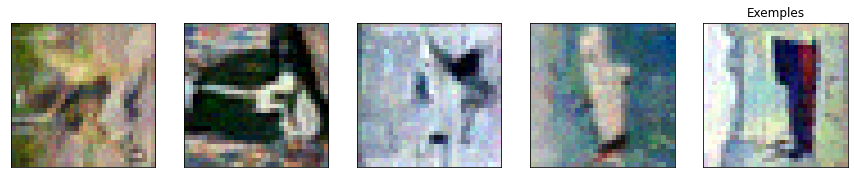

Test Error: 
 Accuracy: 11.7%, Avg loss: 3.043747 

Epsilon : 0.07265221878224974


  0%|          | 0/79 [00:00<?, ?it/s]

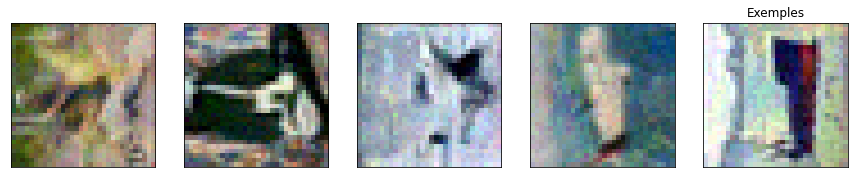

Test Error: 
 Accuracy: 8.7%, Avg loss: 3.343276 

Epsilon : 0.07925696594427245


  0%|          | 0/79 [00:00<?, ?it/s]

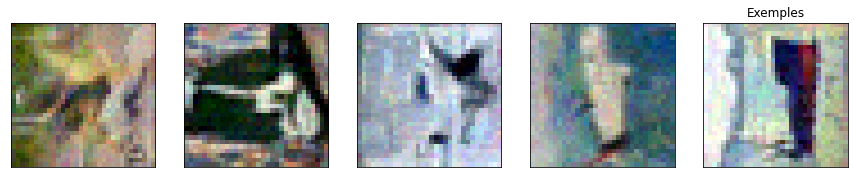

Test Error: 
 Accuracy: 6.7%, Avg loss: 3.624573 

Epsilon : 0.08586171310629515


  0%|          | 0/79 [00:00<?, ?it/s]

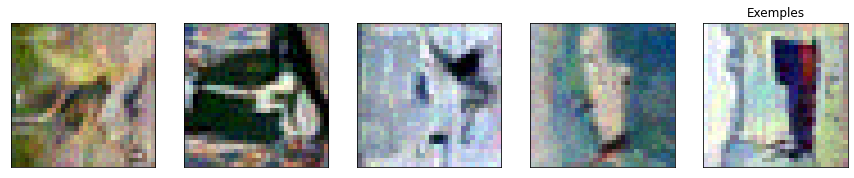

Test Error: 
 Accuracy: 5.3%, Avg loss: 3.897666 

Epsilon : 0.09246646026831785


  0%|          | 0/79 [00:00<?, ?it/s]

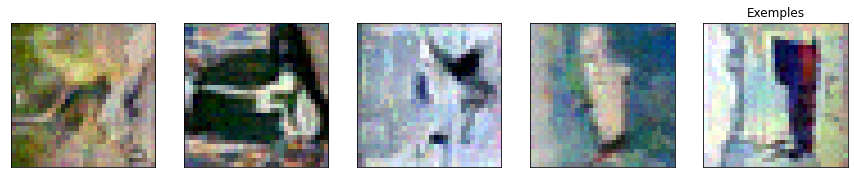

Test Error: 
 Accuracy: 3.9%, Avg loss: 4.159652 

Epsilon : 0.09907120743034055


  0%|          | 0/79 [00:00<?, ?it/s]

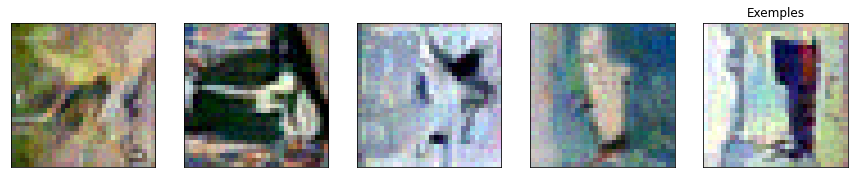

Test Error: 
 Accuracy: 3.0%, Avg loss: 4.391119 

Epsilon : 0.10567595459236326


  0%|          | 0/79 [00:00<?, ?it/s]

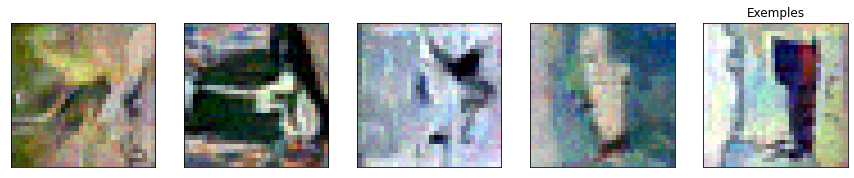

Test Error: 
 Accuracy: 2.5%, Avg loss: 4.605549 

Epsilon : 0.11228070175438597


  0%|          | 0/79 [00:00<?, ?it/s]

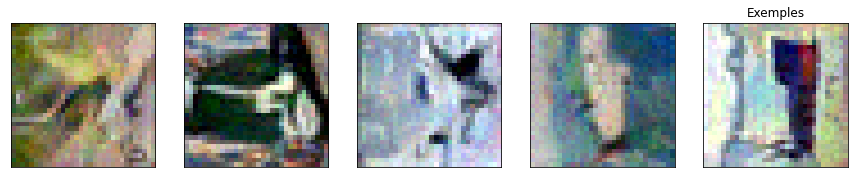

Test Error: 
 Accuracy: 2.0%, Avg loss: 4.806612 

Epsilon : 0.11888544891640866


  0%|          | 0/79 [00:00<?, ?it/s]

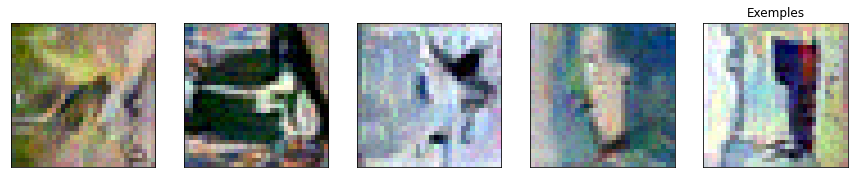

Test Error: 
 Accuracy: 1.6%, Avg loss: 4.960069 

Epsilon : 0.12549019607843137


  0%|          | 0/79 [00:00<?, ?it/s]

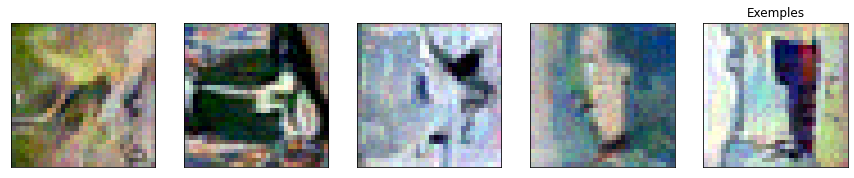

Test Error: 
 Accuracy: 1.7%, Avg loss: 4.961518 



In [ ]:
# mobilenetv2_adv = copy.copy(mobilenetv2)
# mobilenetv2_adv.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/mobilenetv2_adv.pt"))

def add_noise(X):
  X = X + 8/255*torch.randn(*X.shape).cuda()
  return torch.clamp(X,0.,1.)


params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "attack" : "PGD",
    "noise": add_noise,
    "denoiser" :None

}

epsilons_adv_w_noise, accuracies_adv_w_noise = pgd_attack_effect_on_accuracy(resnet20_adv,device,testloader,params)

  0%|          | 0/79 [00:00<?, ?it/s]

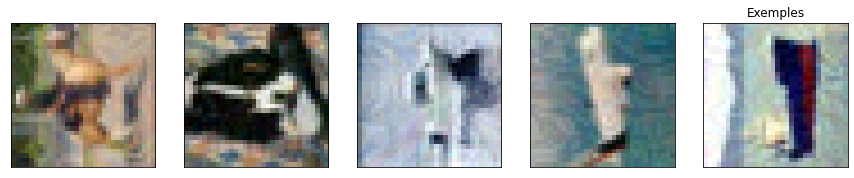

Test Error: 
 Accuracy: 1.3%, Avg loss: 29.702495 



In [ ]:
params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "attack" : "PGD",
    "noise": None,
    "denoiser" :None

}

test_pgd(wide_resnet50_2,device,testloader,
         steps=100,
         epsilon=8/255,
         alpha=3/255,
         params=params)

  0%|          | 0/79 [00:00<?, ?it/s]

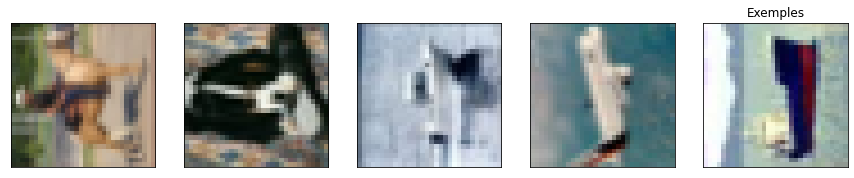

Test Error: 
 Accuracy: 71.1%, Avg loss: 0.698831 



In [ ]:
test_cw(resnet20_adv,device,testloader,
         steps=100,
         epsilon=0.1,
         alpha=3/255,
         params=params)

(0.0, 0.05)

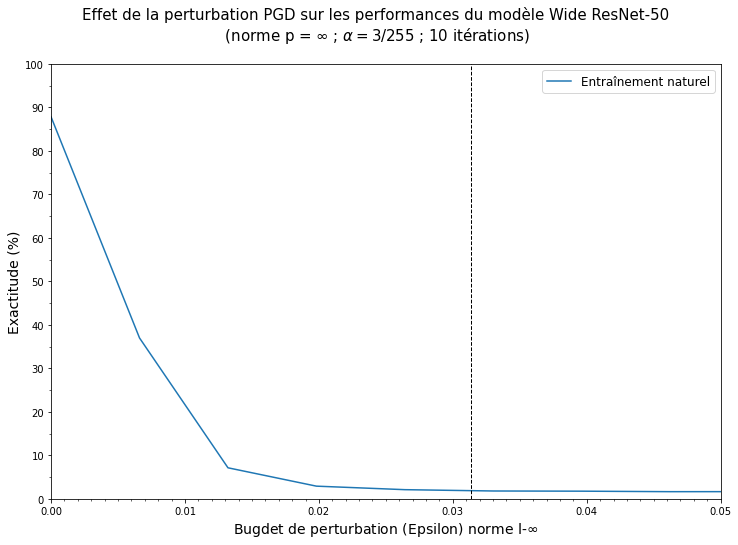

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.001))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.05])

(0.0, 0.13)

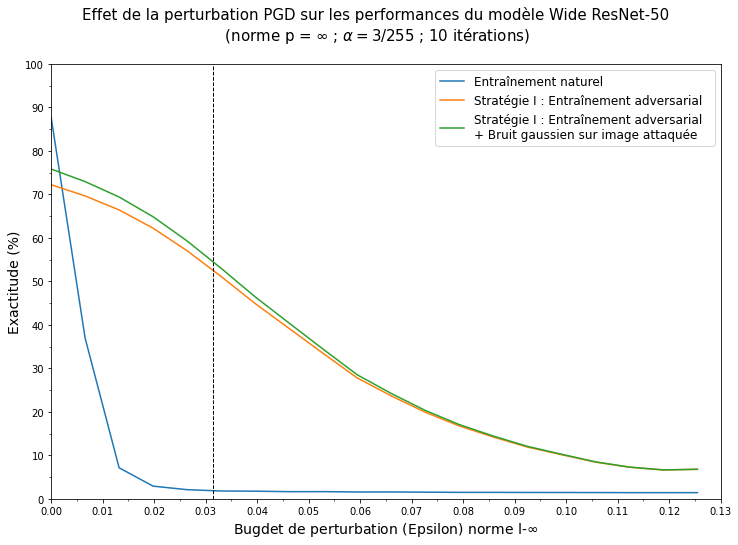

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
ax.plot(epsilons_,accuracy_adv_training_wide_Resnet50_2)
ax.plot(epsilons_,accuracy_adv_training_noise_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Stratégie I : Entraînement adversarial", 
            "Stratégie I : Entraînement adversarial  \n+ Bruit gaussien sur image attaquée"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.13])

# Defense Strategy II : Autoencoder Denoising on input images

Entrainement du modèle de défense avec un autoencodeur sparse (DDSA)

In [ ]:
# torch.save(autoencoder.state_dict(), "autoencoder_ddsa.pt")
# torch.save(autoencoder.state_dict(), "/content/drive/MyDrive/model_CIFAR/autoencoder_ddsa_clean_pert.pt")
# torch.save(mobilenetv2_defense.state_dict(), "/content/drive/MyDrive/model_CIFAR/mobilenetv2_defense_clean_pert.pt")
autoencoder.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/autoencoder_ddsaV2.pt"))

<All keys matched successfully>

In [34]:
from training import adversarial_training_defense
params = {"epochs" : 100,
    "epsilon" : 8/255, #epsilon infini
    "n_iter" : 7,
    "alpha": 3/255, # alpha infini
    "num_exemples":5,
    "use_FGSM" : True,
    "use_autoencoder" : True,

    "noise_factor" : 0.05,

    "params_autoencoder":{  
        "lr" : 0.001 # 0 pour freeze l'autoencodeur (de-bruitage)   
    },
    "params_model":{
        "lr" : 0.001 # 0 pour freeze le modele
    }
}

resnet20_defense = copy.copy(resnet20)
adversarial_training_defense(resnet20_defense,autoencoder,device,trainloader,testloader,params)

  0%|          | 0/391 [00:00<?, ?it/s]/home/imaginat0r/.local/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/imaginat0r/Documents/Dauphine/Courses/Projet_Sciences_Données/Projet1_Adversarial_Robustness/training.py:357: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs_ = torch.tensor(outputs,requires_grad=False)
/home/imaginat0r/Documents/Dauphine/Courses/Projet_Sciences_Données/Projet1_Adversarial_Robustness/utils.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(perturbed_data).to(devi

KeyboardInterrupt: 

In [36]:
# mobilenetv2_defense = copy.copy(mobilenetv2)
# mobilenetv2_defense.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/mobilenetv2_defense_clean_pert.pt"))
# autoencoder.load_state_dict(torch.load("/content/drive/MyDrive/model_CIFAR/autoencoder_deep_denoiser.pt"))
from evaluate import pgd_attack_effect_on_accuracy

def add_noise(X):
  X = X + 0.05*torch.randn(*X.shape).cuda()
  return torch.clamp(X,0.,1.)



params = {
    "epsilons" : np.linspace(0,32/255,20),
    "n_iter" : 10,
    "alpha":  3/255, # alpha infini
    "num_exemples": 5,
    "denoiser": autoencoder,
    "noise" : None,
    "attack" : "PGD"

}


epsilons_defense, accuracies_defense = pgd_attack_effect_on_accuracy(resnet20_defense,device,testloader,params)


Epsilon : 0.0


  3%|▎         | 2/79 [00:10<06:36,  5.15s/it]


KeyboardInterrupt: 

(0.0, 0.13)

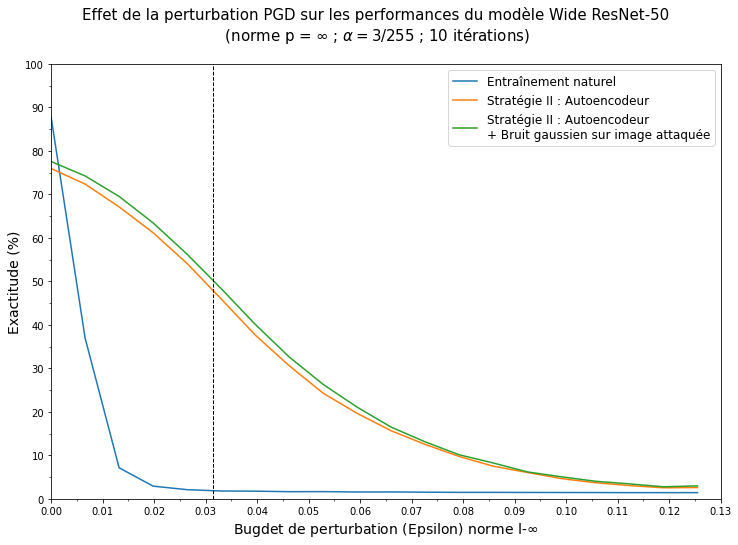

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
ax.plot(epsilons_,accuracies_autoencodeur_wide_Resnet50_2)
ax.plot(epsilons_,accuracies_autoencodeur_noise_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Stratégie II : Autoencodeur", 
            "Stratégie II : Autoencodeur  \n+ Bruit gaussien sur image attaquée"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.13])

## Comparaisons

(0.0, 0.13)

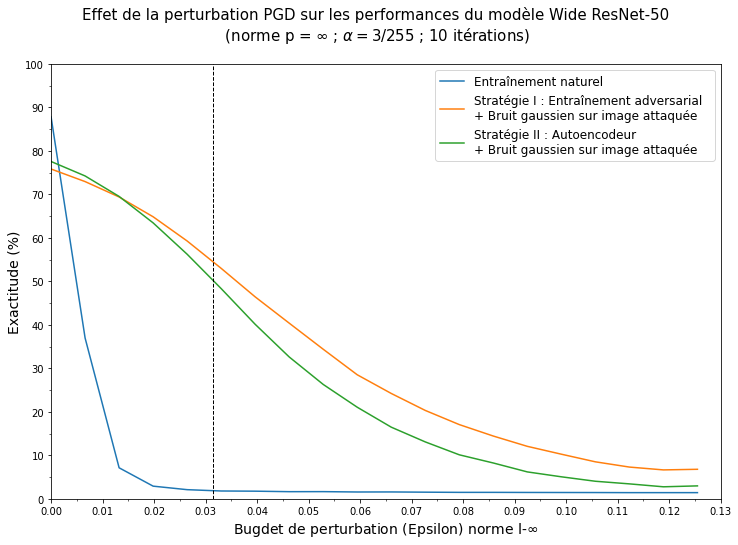

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
X_Y_LABEL_SIZE = 14
TITLE_SIZE = 15

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(epsilons_,accuracy_naturel_wide_Resnet50_2)
ax.plot(epsilons_,accuracy_adv_training_noise_wide_Resnet50_2)
ax.plot(epsilons_,accuracies_autoencodeur_noise_wide_Resnet50_2)
plt.xlabel(r"Bugdet de perturbation (Epsilon) norme l-$\infty$",fontsize=X_Y_LABEL_SIZE)
plt.ylabel("Exactitude (%)",fontsize=X_Y_LABEL_SIZE)
fig.suptitle('Effet de la perturbation PGD sur les performances du modèle Wide ResNet-50\n'+r' (norme p = $\infty$ ; $\alpha = 3/255$ ; 10 itérations)', fontsize=TITLE_SIZE)
ax.xaxis.set_major_locator(MultipleLocator(0.01))
ax.xaxis.set_minor_locator(MultipleLocator(0.005))

ax.axvline(x=8/255, color='k',lw=1,linestyle="--")

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.legend(["Entraînement naturel",
            "Stratégie I : Entraînement adversarial  \n+ Bruit gaussien sur image attaquée", 
            "Stratégie II : Autoencodeur  \n+ Bruit gaussien sur image attaquée"],loc=1, prop={'size': 12})

plt.ylim([0,100])
plt.xlim([0,0.13])